## 1. Fast-RCNN

In [46]:
import cv2
import torch
import numpy as np
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.transforms import functional as F
from pathlib import Path

In [47]:
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [48]:
def preprocess_image(image):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tensor = F.to_tensor(rgb)
    return tensor

In [49]:
def object_detection(image, model, threshold=0.9):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    tensor = preprocess_image(image).unsqueeze(0).to(device)
    with torch.no_grad():
        predictions = model(tensor)

    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    classes = [1, 37]
    results = []
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold and label in classes:
            results.append((box, label, score))
    return results

In [50]:
def process_frames(video_path, output_folder="Output Frames", frame_skip=5):
    Path(output_folder).mkdir(exist_ok=True, parents=True)
    cap = cv2.VideoCapture(video_path)
    fcount = 0
    pcount = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if fcount % frame_skip == 0:
            detections = object_detection(frame, model)

            for box, label, score in detections:
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f"ID: {label} {score:.2f}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            output_path = f"{output_folder}/frame_{pcount:04d}.jpg"
            cv2.imwrite(output_path, frame)
            pcount += 1

        fcount += 1
    print("Successfully used FastRCNN for Bounding Box Detection!")

    cap.release()

In [51]:
if __name__ == "__main__":
    video_path = "/workspaces/eng-ai-agents/Assignment5/Football match [l3NJNFmg09k].f136.mp4"
    process_frames(video_path)

Successfully used FastRCNN for Bounding Box Detection!


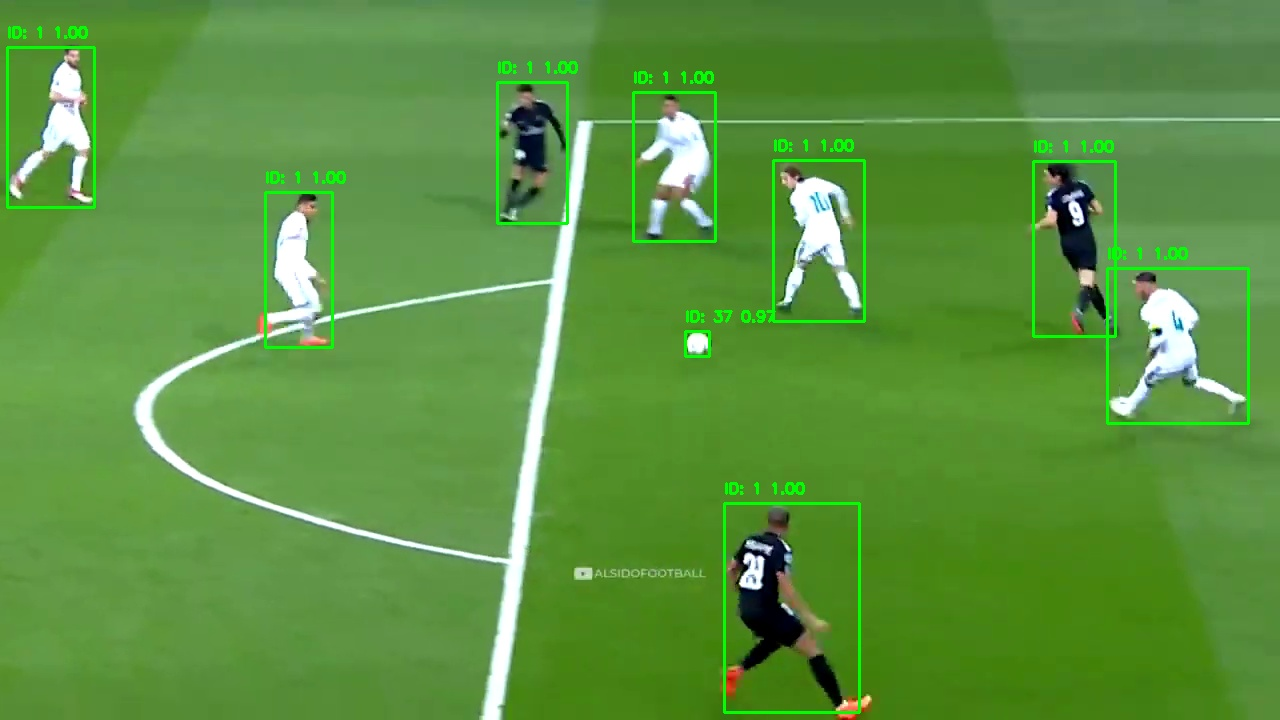

In [59]:
from IPython.display import Image
Image(filename='/workspaces/eng-ai-agents/Assignment5/Output Frames/frame_0079.jpg')

## 2. DEEP SORT

In [52]:
class KalmanFilter:
    def __init__(self):
        self.state_dim = 8
        self.meas_dim = 4
        self.transition_matrix = np.eye(self.state_dim)
        self.measurement_matrix = np.eye(self.meas_dim, self.state_dim)
        self.process_noise = np.eye(self.state_dim) * 1e-2
        self.measurement_noise = np.eye(self.meas_dim) * 1e-1
        self.state_covariance = np.eye(self.state_dim)

    def predict(self, state):
        state = np.dot(self.transition_matrix, state)
        self.state_covariance = np.dot(
            np.dot(self.transition_matrix, self.state_covariance), self.transition_matrix.T
        ) + self.process_noise
        return state

    def update(self, state, measurement):
        innovation_cov = np.dot(
            np.dot(self.measurement_matrix, self.state_covariance), self.measurement_matrix.T
        ) + self.measurement_noise
        kalman_gain = np.dot(
            np.dot(self.state_covariance, self.measurement_matrix.T), np.linalg.inv(innovation_cov)
        )

        innovation = measurement - np.dot(self.measurement_matrix, state)
        state = state + np.dot(kalman_gain, innovation)

        self.state_covariance = np.dot(
            np.eye(self.state_dim) - np.dot(kalman_gain, self.measurement_matrix),
            self.state_covariance,
        )
        return state

In [53]:
def iou_score(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    intersection = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = intersection / float(boxA_area + boxB_area - intersection)
    return iou

def iou_matching(detections, tracks, iou_threshold=0.3):
    matches = []
    unmatched_detects = []
    unmatched_tracks = []

    for t_id, track in enumerate(tracks):
        best_match = None
        best_iou = iou_threshold
        for d_id, detection in enumerate(detections):
            iou = iou_score(track['bbox'], detection['bbox'])
            if iou > best_iou:
                best_match = d_id
                best_iou = iou

        if best_match is not None:
            matches.append((t_id, best_match))
        else:
            unmatched_tracks.append(t_id)

    unmatched_detects = [d_id for d_id in range(len(detections)) if d_id not in [m[1] for m in matches]]

    return matches, unmatched_detects, unmatched_tracks


In [54]:
from scipy.optimize import linear_sum_assignment

def hungarian_algo(cost_matrix):
    row, col = linear_sum_assignment(cost_matrix)
    return list(zip(row, col))


In [55]:
def distance(tracks, detects):
    distances = np.zeros((len(tracks), len(detects)))
    for i, track in enumerate(tracks):
        for j, detection in enumerate(detects):
            distances[i, j] = 1 - iou_score(track['bbox'], detection['bbox'])
    return distances

In [56]:
class Tracker:
    def __init__(self):
        self.tracks = []
        self.next_id = 0

    def update(self, detects):
        if len(self.tracks) == 0:
            for det in detects:
                self.tracks.append({'id': self.next_id, 'bbox': det['bbox'], 'age': 1})
                self.next_id += 1
        else:
            cost_matrix = distance(self.tracks, detects)
            assignments = hungarian_algo(cost_matrix)

            for t_id, d_id in assignments:
                self.tracks[t_id]['bbox'] = detects[d_id]['bbox']
                self.tracks[t_id]['age'] = 1

            unmatched_detects = set(range(len(detects))) - set([a[1] for a in assignments])
            for d_id in unmatched_detects:
                self.tracks.append({'id': self.next_id, 'bbox': detects[d_id]['bbox'], 'age': 1})
                self.next_id += 1

        self.tracks = [t for t in self.tracks if t['age'] < 5]

In [57]:
import torchvision.transforms as T
from torchvision import models

feature_extractor = models.resnet50(pretrained=True)
feature_extractor.eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features_from_frame(frame, bbox):
    x1, y1, x2, y2 = map(int, bbox)
    crop = frame[y1:y2, x1:x2]

    tensor = transform(crop)
    batch = tensor.unsqueeze(0)

    with torch.no_grad():
        features = feature_extractor(batch)

    feature_vector = features.squeeze().cpu().numpy()
    return feature_vector

In [58]:
def process_video(video_path, output_video="Output_Video.mp4"):
    tracker = Tracker()

    cap = cv2.VideoCapture(video_path)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        detects = object_detection(frame, model)

        detect_data = []
        for box, label, score in detects:
            feature_vector = extract_features_from_frame(frame, box)
            detect_data.append({
                'bbox': box,
                'label': label,
                'score': score,
                'features': feature_vector
            })

        tracker.update(detect_data)

        for track in tracker.tracks:
            x1, y1, x2, y2 = map(int, track['bbox'])
            track_id = track['id']
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        out.write(frame)

    cap.release()
    out.release()
    print("Successfully implemented DEEP SORT!")

if __name__ == "__main__":
    video_path = "/workspaces/eng-ai-agents/Assignment5/Football match [l3NJNFmg09k].f136.mp4"
    process_video(video_path)

Successfully implemented DEEP SORT!
